In [49]:
import pandas as pd

# Load full index data
df = pd.read_csv("../data/159992_chan_analysis.csv")

# Filter for sh000016 and immediately copy to avoid SettingWithCopyWarning
# df_50 = df.loc[df['index_code'] == 'sh000016'].copy()
df_50 = df
print('Loaded rows:', len(df), 'Filtered rows:', len(df_50))
print(df_50.head())
# get all columns names

Loaded rows: 1192 Filtered rows: 1192
   index_code        date   open   high    low  close     volume
0      159992  2020-11-04  1.369  1.373  1.357  1.359  128311000
1      159992  2020-11-05  1.374  1.388  1.359  1.378  153986400
2      159992  2020-11-06  1.331  1.374  1.313  1.371  320241200
3      159992  2020-11-09  1.356  1.368  1.330  1.332  256135500
4      159992  2020-11-10  1.344  1.389  1.339  1.373  213761200


In [50]:
from ChanAnalysis import ChanAnalysis
# Initialize ChanAnalysis AFTER class definition
# Prepare df_50
if not pd.api.types.is_datetime64_any_dtype(df_50['date']):
    df_50['date'] = pd.to_datetime(df_50['date'], errors='coerce')

df_50 = df_50.sort_values('date').dropna(subset=['date']).reset_index(drop=True)
chan = ChanAnalysis(df_50)
print('Initialized ChanAnalysis. Original bars:', len(df_50), 'Compressed bars:', len(chan.comp_df))

Initialized ChanAnalysis. Original bars: 1192 Compressed bars: 878


In [51]:
import sys
sys.path.append('..')
from tdx_func import boduan
# Calculate boduan indicators
boduan_results = boduan(chan.comp_df)

In [52]:
# Compute fractals & strokes sequentially
fractals_initial = chan.find_fractal()
strokes_initial = chan.find_strokes(fractals_initial)
print('Initial fractals:', len(fractals_initial), 'Initial strokes:', len(strokes_initial))

chan.recompress_after_first_stroke()
fractals = chan.find_fractal()
strokes = chan.find_strokes(fractals)
# Enhance strokes list with convenience min/max for later stop reference (optional)
for s in strokes:
    s['low'] = min(s['start_price'], s['end_price'])
    s['high'] = max(s['start_price'], s['end_price'])



Initial fractals: 347 Initial strokes: 254


In [53]:

# Segments, Zhongshu and Buy/Sell points
segments = chan.find_segments(strokes)
print('Segments:', len(segments))
zhongshu = chan.find_zhongshu(strokes)
print('Zhongshu merged:', len(zhongshu))

points_basic = chan.find_buy_sell_points(segments, zhongshu)
points_adv = chan.find_advanced_buy_sell_points(segments, zhongshu, dist_threshold=0.03, tiny_penetration=0.04)
print('Basic points:', len(points_basic), 'Advanced points:', len(points_adv))

# Enrich points with reference levels for potential stop-loss logic
# For buys: ref_low = recent swing low (previous segment end_price if down) or min of previous 2 strokes lows
# For sells: ref_high analogously.
# This keeps original pattern classification but adds fields.


def _infer_reference_levels(points, segments):
    seg_map_end = {seg['end_index']: seg for seg in segments}
    # Build a lookup by index to segment containing that index (simple last containing)
    seg_by_index = {}
    for seg in segments:
        for i in range(seg['start_index'], seg['end_index']+1):
            seg_by_index[i] = seg
    enriched = []
    for p in points:
        seg_context = seg_by_index.get(p['index'])
        ref_low = None; ref_high = None
        if seg_context:
            seg_idx = segments.index(seg_context)
            # previous segment for reference
            prev_seg = segments[seg_idx-1] if seg_idx>0 else None
            if p['type']=='buy':
                # use lower of prev down segment if it was down
                if prev_seg and prev_seg['direction']=='down':
                    ref_low = min(prev_seg['start_price'], prev_seg['end_price'])
                # fallback: take min of last 2 strokes lows inside prev_seg
                if ref_low is None and prev_seg:
                    lows = []
                    for st in prev_seg['strokes']:
                        lows.append(min(st['start_price'], st['end_price']))
                    ref_low = min(lows) if lows else None
            elif p['type']=='sell':
                if prev_seg and prev_seg['direction']=='up':
                    ref_high = max(prev_seg['start_price'], prev_seg['end_price'])
                if ref_high is None and prev_seg:
                    highs = []
                    for st in prev_seg['strokes']:
                        highs.append(max(st['start_price'], st['end_price']))
                    ref_high = max(highs) if highs else None
        p_en = dict(p)
        if ref_low is not None:
            p_en['ref_low'] = ref_low
            # optional tight stop (e.g., 1.2% below)
            p_en['stop_loss'] = ref_low * 0.988
        if ref_high is not None:
            p_en['ref_high'] = ref_high
            p_en['stop_loss'] = ref_high * 1.012  # for sells: protective stop above
        enriched.append(p_en)
    return enriched

points_all_raw = points_basic + points_adv
points_all = _infer_reference_levels(points_all_raw, segments)
points_df = pd.DataFrame(points_all).sort_values('date')
print('Total unique points (enriched):', len(points_df))
points_df.head()

Segments: 123
Zhongshu merged: 49
Basic points: 57 Advanced points: 70
Total unique points (enriched): 127


,index,date,type,pattern,price,description,ref_low,stop_loss,ref_high
0,22,2020-12-08,buy,yi_mai,1.320,Segment reversal yi mai,1.268,1.252784,NaN
57,22,2020-12-08,buy,yi_mai,1.320,Segment reversal yi mai,1.268,1.252784,NaN
1,46,2021-01-08,sell,yi_mai,1.450,Segment reversal yi mai,NaN,1.371260,1.355
58,46,2021-01-08,sell,yi_mai,1.450,Segment reversal yi mai,NaN,1.371260,1.355
2,57,2021-01-25,buy,yi_mai,1.534,Segment reversal yi mai,1.396,1.379248,NaN


Subset fractals: 29, strokes: 22, segments: 10, zhongshu: 3, points: 8


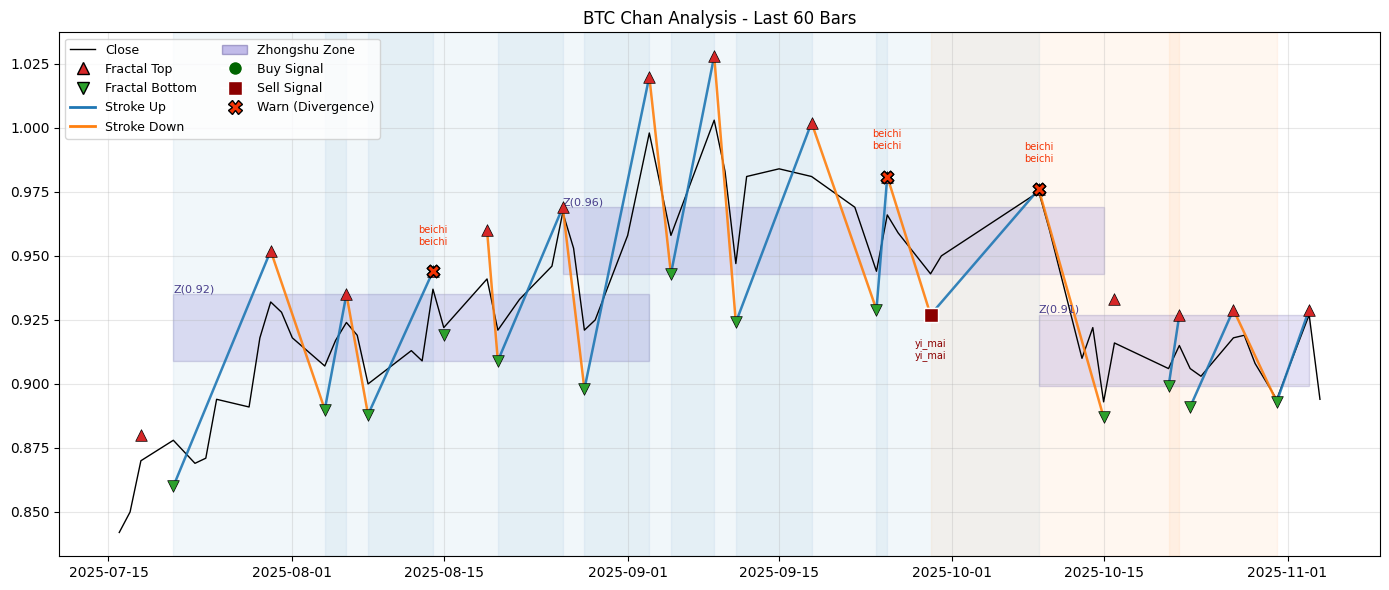

In [54]:
# Import the plotting function - reload to get the updated version
import importlib
from matplotlib import pyplot as plt
import plot_util
importlib.reload(plot_util)
from plot_util import plot_chan_analysis

# Plot configuration
# Choose either last_n (e.g., 300) or a date window (start_date, end_date)
last_n = 60  # set to None to use date range instead
start_date = None  # e.g., '2022-01-01'
end_date = None    # e.g., '2023-12-31'
text_offset_ratio = 0.01  # vertical offset for text labels as ratio of price range
stack_step_ratio = 0.005  # vertical step between stacked labels as ratio of price range

# Use the function to create the plot
fig, ax = plot_chan_analysis(
    chan=chan,
    fractals=fractals,
    strokes=strokes,
    segments=segments,
    zhongshu=zhongshu,
    points_df=points_df,
    last_n=60,  # Show last 60 bars
    title="BTC Chan Analysis - Last 60 Bars"
)

plt.show()

Subset fractals: 29, strokes: 22, segments: 10, zhongshu: 3, points: 8
Boduan data mapped: C1 valid values: 52


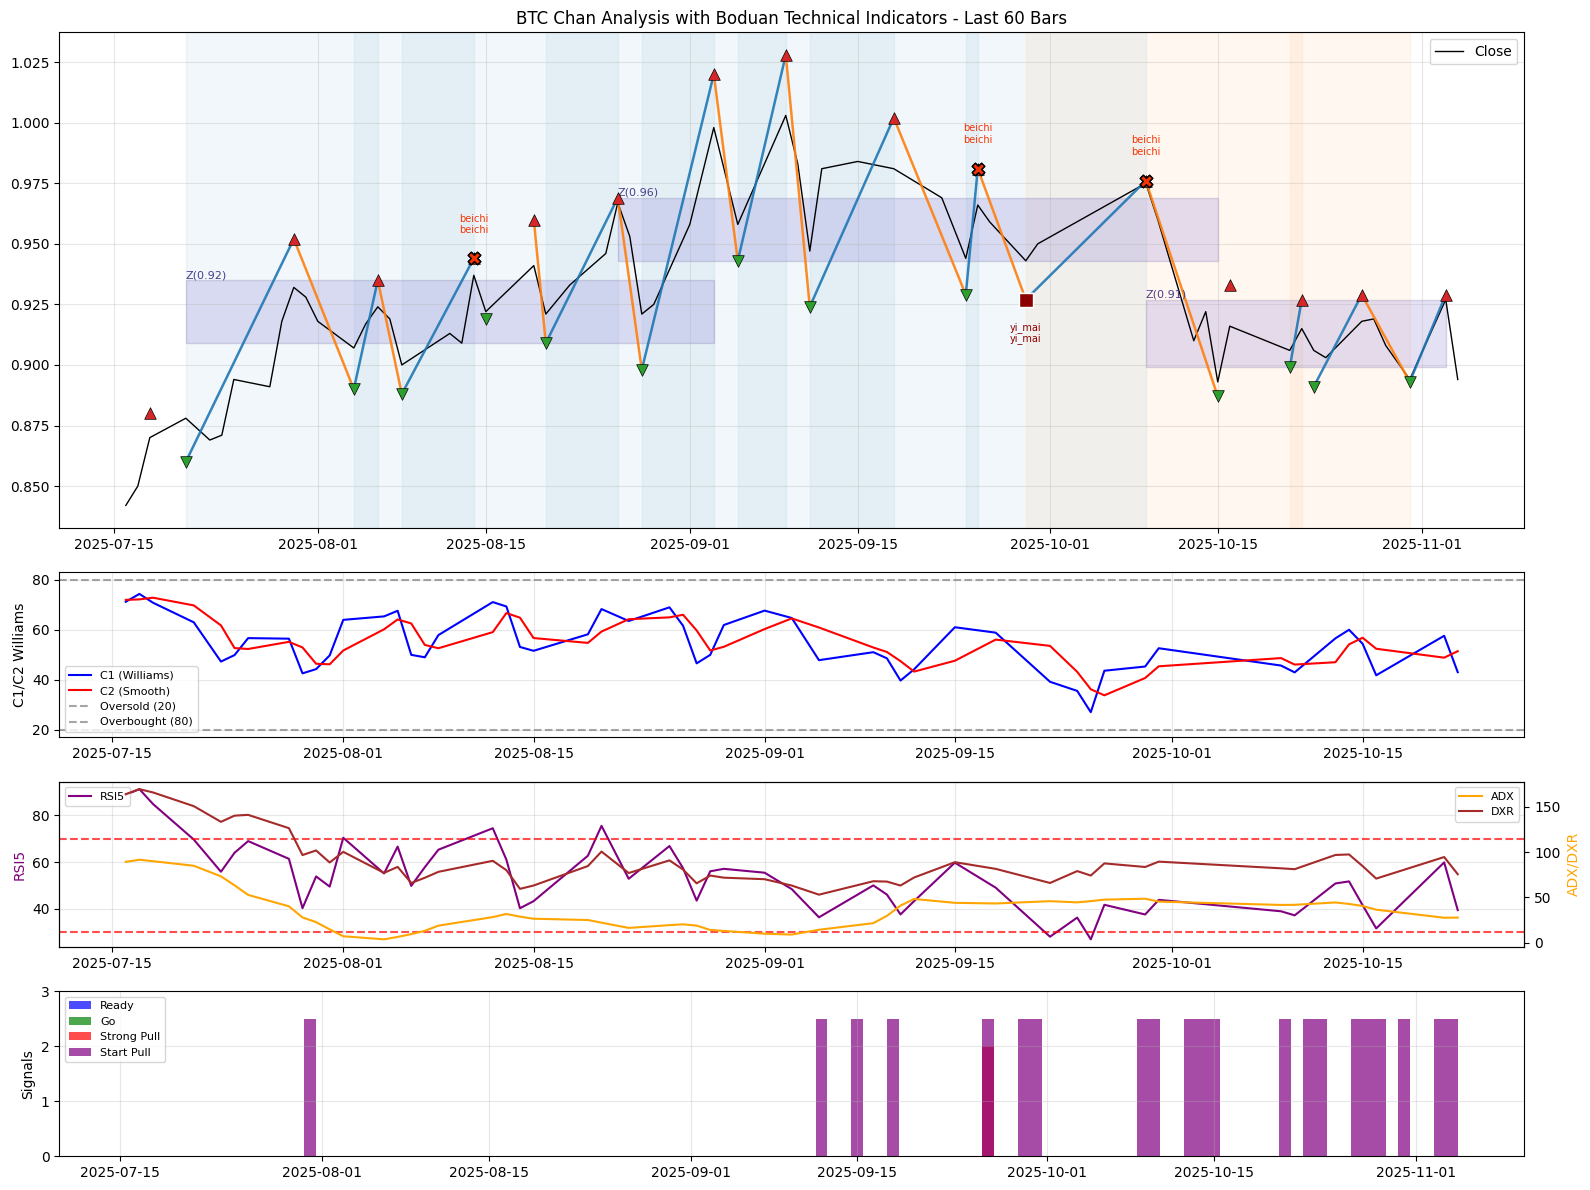

In [55]:
# Plot Chan analysis with boduan indicators using the corrected function
# First reload the fixed plot_util module
import importlib
import plot_util
importlib.reload(plot_util)
from plot_util import plot_chan_analysis

fig, axes = plot_chan_analysis(
    chan=chan,
    fractals=fractals,
    strokes=strokes,
    segments=segments,
    zhongshu=zhongshu,
    points_df=points_df,
    boduan_results=boduan_results,  # This now works with proper index mapping
    last_n=60,  # Show last 60 bars
    title="BTC Chan Analysis with Boduan Technical Indicators - Last 60 Bars"
)

plt.show()

In [56]:
# Summary
print('Fractals:', len(fractals))
print('Strokes:', len(strokes))
print('Segments:', len(segments))
print('Zhongshu:', len(zhongshu))
print('Points total:', len(points_df))
if not points_df.empty:
    print(points_df.groupby(['type','pattern']).size())
# points_df.tail(10)

Fractals: 347
Strokes: 248
Segments: 123
Zhongshu: 49
Points total: 127
type  pattern
buy   er_mai      4
      san_mai     6
      yi_mai     44
sell  er_mai      4
      san_mai     7
      yi_mai     44
warn  beichi     18
dtype: int64


In [57]:
# Define atr_map before it's used for pm.current_atr_pct.
# Assumptions:
# - Price DataFrame is `df` with columns: 'high','low','close'.
# - We'll compute a standard ATR (Wilder) over a default window (e.g. 14) and then
#   convert to a percentage of close to match usage `pm.current_atr_pct`.
# - atr_map is a dict keyed by integer index (row number) mapping to ATR% value.
# If existing code later expects a different window, adjust `atr_period` below.

atr_period = 14
required_cols = {'high','low','close'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"DataFrame df missing required columns for ATR calculation: {missing}")

# True Range components
high = df['high']
low = df['low']
close_prev = df['close'].shift(1)
tr = pd.concat([
    high - low,
    (high - close_prev).abs(),
    (low - close_prev).abs()
], axis=1).max(axis=1)

# Wilder's smoothing for ATR
atr = tr.ewm(alpha=1/atr_period, adjust=False).mean()
atr_pct = atr / df['close']

atr_map = atr_pct.to_dict()
print(f"ATR map created: period={atr_period}, entries={len(atr_map)}")
# Preview last few
print(atr_pct.tail())

ATR map created: period=14, entries=1192
1187    0.030286
1188    0.029487
1189    0.030409
1190    0.029929
1191    0.031853
dtype: float64


In [58]:
import numpy as np
# Chan Theory Position Management and Trading Strategy
class ChanPositionManager:
    def __init__(self, initial_capital=100000, commission_rate=0.001):
        self.initial_capital = initial_capital
        self.capital = initial_capital
        self.position = 0  # Current position
        self.position_cost = 0  # Position cost
        self.trades = []  # Trade records
        self.commission_rate = commission_rate  # Commission rate (e.g., 0.001 = 0.1%)
        self.total_commission_paid = 0  # Track total commission paid
        
    def calculate_position_size(self, signal_strength, current_price, risk_per_trade=0.02):
        """Calculate position size based on signal strength"""
        if signal_strength >= 0.8:
            return min(0.8, self.capital * risk_per_trade * 20 / current_price)  # High signal strength, large position
        elif signal_strength >= 0.6:
            return min(0.6, self.capital * risk_per_trade * 15 / current_price)  # Medium signal strength
        elif signal_strength >= 0.4:
            return min(0.4, self.capital * risk_per_trade * 10 / current_price)  # Low signal strength, small position
        else:
            return 0  # Signal too weak, no trading
    
    def execute_trade(self, date, price, action, signal_strength, reason):
        """Execute trade"""
        if action == 'buy' and self.position == 0:
            position_size = self.calculate_position_size(signal_strength, price)
            if position_size > 0:
                shares = int(self.capital * position_size / price)
                gross_cost = shares * price
                commission = gross_cost * self.commission_rate
                total_cost = gross_cost + commission
                
                if total_cost <= self.capital:
                    self.position = shares
                    self.position_cost = price
                    self.capital -= total_cost
                    self.total_commission_paid += commission
                    
                    self.trades.append({
                        'date': date,
                        'action': 'buy',
                        'price': price,
                        'shares': shares,
                        'gross_cost': gross_cost,
                        'commission': commission,
                        'total_cost': total_cost,
                        'signal_strength': signal_strength,
                        'reason': reason,
                        'capital_after': self.capital,
                        'position_value': shares * price
                    })
        
        elif action == 'sell' and self.position > 0:
            gross_revenue = self.position * price
            commission = gross_revenue * self.commission_rate
            net_revenue = gross_revenue - commission
            gross_profit = gross_revenue - (self.position * self.position_cost)
            net_profit = net_revenue - (self.position * self.position_cost)
            
            self.capital += net_revenue
            self.total_commission_paid += commission
            
            self.trades.append({
                'date': date,
                'action': 'sell',
                'price': price,
                'shares': self.position,
                'gross_revenue': gross_revenue,
                'commission': commission,
                'net_revenue': net_revenue,
                'gross_profit': gross_profit,
                'profit': net_profit,  # Net profit after commission
                'signal_strength': signal_strength,
                'reason': reason,
                'capital_after': self.capital,
                'return_rate': net_profit / (self.position * self.position_cost)
            })
            
            self.position = 0
            self.position_cost = 0
    
    def get_current_value(self, current_price):
        """Get current total asset value"""
        return self.capital + self.position * current_price
    
    def get_performance_metrics(self):
        """Calculate strategy performance metrics"""
        if not self.trades:
            return {}
        
        profits = [trade.get('profit', 0) for trade in self.trades if 'profit' in trade]
        returns = [trade.get('return_rate', 0) for trade in self.trades if 'return_rate' in trade]
        
        total_trades = len([t for t in self.trades if t['action'] == 'sell'])
        winning_trades = len([p for p in profits if p > 0])
        
        return {
            'total_trades': total_trades,
            'winning_trades': winning_trades,
            'win_rate': winning_trades / total_trades if total_trades > 0 else 0,
            'total_profit': sum(profits),
            'total_commission_paid': self.total_commission_paid,
            'avg_return': np.mean(returns) if returns else 0,
            'max_return': max(returns) if returns else 0,
            'min_return': min(returns) if returns else 0
        }

def calculate_signal_strength(buy_sell_points, segments, current_index):
    """Calculate current trading signal strength"""
    # This is a simplified signal strength calculation
    # In practice, more factors can be considered: divergence, zhongshu, level, etc.
    
    base_strength = 0.5
    
    # Find recent segment information
    recent_segments = [s for s in segments if s['end_index'] <= current_index]
    if len(recent_segments) >= 2:
        last_segment = recent_segments[-1]
        prev_segment = recent_segments[-2]
        
        # If the last two segments have opposite directions, increase signal strength
        if last_segment['direction'] != prev_segment['direction']:
            base_strength += 0.2
        
        # If segment contains more strokes, increase signal strength
        if last_segment['strokes_count'] >= 3:
            base_strength += 0.1
    
    return min(1.0, base_strength)

print("Position management system created with commission fee support")

Position management system created with commission fee support


In [59]:
# Chan Theory Backtesting System
import numpy as np
import warnings
warnings.filterwarnings('ignore')

class ChanBacktester:
    def __init__(self, price_data, buy_sell_points, segments, initial_capital=100000, commission_rate=0.001):
        self.price_data = price_data.copy()
        self.buy_sell_points = buy_sell_points.copy()
        self.segments = segments
        self.initial_capital = initial_capital
        self.commission_rate = commission_rate
        self.pm = ChanPositionManager(initial_capital, commission_rate)
        self.equity_curve = []
        self.trade_log = []
        
        # Ensure price data is sorted by date
        self.price_data['date'] = pd.to_datetime(self.price_data['date'])
        self.price_data = self.price_data.sort_values('date').reset_index(drop=True)
        
        # Preprocess buy/sell points data
        if not self.buy_sell_points.empty:
            self.buy_sell_points['date'] = pd.to_datetime(self.buy_sell_points['date'])
            self.buy_sell_points = self.buy_sell_points.sort_values('date').reset_index(drop=True)
    
    def calculate_enhanced_signal_strength(self, point, current_index):
        """Enhanced signal strength calculation"""
        base_strength = 0.5
        pattern = point['pattern']
        
        # Adjust base strength according to signal type
        pattern_weights = {
            'yi_mai': 0.7,      # Yi mai
            'er_mai': 0.8,      # Er mai
            'san_mai': 0.9,     # San mai
            'san_mai_confirm': 0.95,  # San mai confirmation
            'beichi_macd': 0.6, # MACD divergence
            'beichi': 0.5       # General divergence
        }
        
        base_strength = pattern_weights.get(pattern, 0.5)
        
        # Consider segment factors
        recent_segments = [s for s in self.segments if s['end_index'] <= current_index]
        if len(recent_segments) >= 2:
            last_seg = recent_segments[-1]
            prev_seg = recent_segments[-2]
            
            # Segment reversal increases strength
            if last_seg['direction'] != prev_seg['direction']:
                base_strength += 0.1
            
            # Segment containing more strokes increases strength
            if last_seg.get('strokes_count', 0) >= 3:
                base_strength += 0.05
        
        # Consider ATR volatility - reduce position when high volatility
        if current_index in atr_map:
            atr_pct_val = atr_map[current_index]
            if atr_pct_val > 0.03:  # High volatility
                base_strength *= 0.8
            elif atr_pct_val < 0.015:  # Low volatility
                base_strength *= 1.1
        
        return min(1.0, base_strength)
    
    def should_stop_loss(self, current_price, entry_price, entry_type, atr_multiplier=2.0):
        """Stop loss judgment"""
        if entry_type == 'buy':
            # Price drop exceeds 2 times ATR after buying
            current_atr = atr_map.get(len(self.equity_curve), 0.02)  # Default 2%
            stop_threshold = entry_price * (1 - current_atr * atr_multiplier)
            return current_price < stop_threshold
        else:  # sell
            current_atr = atr_map.get(len(self.equity_curve), 0.02)
            stop_threshold = entry_price * (1 + current_atr * atr_multiplier)
            return current_price > stop_threshold
    
    def run_backtest(self, commission_rate=None, enable_stop_loss=True):
        """Run backtest"""
        # Use instance commission rate if not provided
        if commission_rate is None:
            commission_rate = self.commission_rate
            
        print(f"Starting Chan Theory strategy backtest with {commission_rate:.3%} commission...")
        
        # Create daily equity curve
        for i, row in self.price_data.iterrows():
            current_date = row['date']
            current_price = row['close']
            current_index = row['index']
            
            # Check for trading signals
            todays_signals = self.buy_sell_points[
                self.buy_sell_points['date'] == current_date
            ] if not self.buy_sell_points.empty else pd.DataFrame()
            
            # Handle stop loss
            if enable_stop_loss and self.pm.position != 0:
                last_trade = self.pm.trades[-1] if self.pm.trades else None
                if last_trade and self.should_stop_loss(
                    current_price, 
                    last_trade['price'], 
                    last_trade['action']
                ):
                    # Execute stop loss
                    action = 'sell' if last_trade['action'] == 'buy' else 'buy'
                    self.pm.execute_trade(
                        current_date, current_price, action, 
                        0.3, f"Stop loss (ATR-based)"
                    )
                    print(f"{current_date.strftime('%Y-%m-%d')}: Stop loss at {current_price:.2f}")
            
            # Handle trading signals
            for _, signal in todays_signals.iterrows():
                if signal['type'] in ['buy', 'sell']:
                    signal_strength = self.calculate_enhanced_signal_strength(
                        signal, current_index
                    )
                    
                    # Execute trade
                    if signal['type'] == 'buy' and self.pm.position == 0:
                        self.pm.execute_trade(
                            current_date, current_price, 'buy',
                            signal_strength, 
                            f"{signal['pattern']} - {signal.get('description', '')}"
                        )
                        if self.pm.trades:  # If trade executed successfully
                            last_trade = self.pm.trades[-1]
                            commission = last_trade.get('commission', 0)
                            print(f"{current_date.strftime('%Y-%m-%d')}: Buy {signal['pattern']} at {current_price:.2f}, strength: {signal_strength:.2f}, commission: ${commission:.2f}")
                    
                    elif signal['type'] == 'sell' and self.pm.position > 0:
                        self.pm.execute_trade(
                            current_date, current_price, 'sell',
                            signal_strength,
                            f"{signal['pattern']} - {signal.get('description', '')}"
                        )
                        if self.pm.trades and self.pm.trades[-1]['action'] == 'sell':
                            last_trade = self.pm.trades[-1]
                            profit = last_trade['profit']
                            commission = last_trade.get('commission', 0)
                            print(f"{current_date.strftime('%Y-%m-%d')}: Sell {signal['pattern']} at {current_price:.2f}, P&L: {profit:.2f}, commission: ${commission:.2f}")
            
            # Record daily equity
            total_value = self.pm.get_current_value(current_price)
            self.equity_curve.append({
                'date': current_date,
                'price': current_price,
                'capital': self.pm.capital,
                'position_value': self.pm.position * current_price,
                'total_value': total_value,
                'position': self.pm.position
            })
        
        print(f"Backtest completed! Total trades: {len([t for t in self.pm.trades if t['action'] == 'sell'])}")
        print(f"Total commission paid: ${self.pm.total_commission_paid:.2f}")
        return self.pm.trades, self.equity_curve
    
    def get_backtest_stats(self):
        """Calculate backtest statistics"""
        if not self.equity_curve:
            return {}
        
        equity_df = pd.DataFrame(self.equity_curve)
        
        # Basic statistics
        final_value = equity_df['total_value'].iloc[-1]
        total_return = (final_value - self.initial_capital) / self.initial_capital
        
        # Daily returns
        equity_df['daily_return'] = equity_df['total_value'].pct_change()
        daily_returns = equity_df['daily_return'].dropna()
        
        # Benchmark return (buy and hold)
        initial_price = equity_df['price'].iloc[0]
        final_price = equity_df['price'].iloc[-1]
        buy_hold_return = (final_price - initial_price) / initial_price
        
        # Annualized return
        days = len(equity_df)
        annualized_return = (1 + total_return) ** (365 / days) - 1 if days > 0 else 0
        
        # Volatility and Sharpe ratio
        volatility = daily_returns.std() * np.sqrt(252)
        sharpe_ratio = (annualized_return - 0.03) / volatility if volatility > 0 else 0  # Assume risk-free rate 3%
        
        # Maximum drawdown
        peak = equity_df['total_value'].expanding().max()
        drawdown = (equity_df['total_value'] - peak) / peak
        max_drawdown = drawdown.min()
        
        # Trading statistics
        performance = self.pm.get_performance_metrics()
        
        stats = {
            'initial_capital': self.initial_capital,
            'final_value': final_value,
            'total_return_pct': total_return * 100,
            'annualized_return_pct': annualized_return * 100,
            'buy_hold_return_pct': buy_hold_return * 100,
            'excess_return_pct': (total_return - buy_hold_return) * 100,
            'volatility_pct': volatility * 100,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown_pct': max_drawdown * 100,
            'total_trades': performance.get('total_trades', 0),
            'win_rate_pct': performance.get('win_rate', 0) * 100,
            'avg_return_per_trade_pct': performance.get('avg_return', 0) * 100,
            'total_profit': performance.get('total_profit', 0),
            'total_commission_paid': performance.get('total_commission_paid', 0),
            'commission_rate_pct': self.commission_rate * 100
        }
        
        return stats

# Create backtester instance with commission rate
backtester = ChanBacktester(chan.comp_df, points_df, segments, initial_capital=100000, commission_rate=0.001)
print("Backtesting system initialized with commission fee support")

Backtesting system initialized with commission fee support


In [60]:
# Run backtest
trades, equity_curve = backtester.run_backtest(commission_rate=0.001, enable_stop_loss=True)

# Get statistical results
stats = backtester.get_backtest_stats()

print("\n=== Chan Theory Strategy Backtest Results ===")
print(f"Initial capital: ¥{stats['initial_capital']:,.0f}")
print(f"Final value: ¥{stats['final_value']:,.0f}")
print(f"Total return: {stats['total_return_pct']:.2f}%")
print(f"Annualized return: {stats['annualized_return_pct']:.2f}%")
print(f"Buy and hold return: {stats['buy_hold_return_pct']:.2f}%")
print(f"Excess return: {stats['excess_return_pct']:.2f}%")
print(f"Volatility: {stats['volatility_pct']:.2f}%")
print(f"Sharpe ratio: {stats['sharpe_ratio']:.2f}")
print(f"Maximum drawdown: {stats['max_drawdown_pct']:.2f}%")
print(f"Total trades: {stats['total_trades']}")
print(f"Win rate: {stats['win_rate_pct']:.1f}%")
print(f"Average return per trade: {stats['avg_return_per_trade_pct']:.2f}%")
print(f"Total P&L: ¥{stats['total_profit']:,.0f}")

Starting Chan Theory strategy backtest with 0.100% commission...
2020-12-08: Buy yi_mai at 1.30, strength: 0.70, commission: $60.00
2021-01-08: Sell yi_mai at 1.43, P&L: 5745.06, commission: $65.81
2021-01-25: Buy yi_mai at 1.51, strength: 0.60, commission: $63.41
2021-02-01: Stop loss at 1.41
2021-03-24: Buy yi_mai at 1.30, strength: 0.60, commission: $60.89
2021-04-30: Sell yi_mai at 1.51, P&L: 9564.09, commission: $70.53
2021-05-24: Buy san_mai at 1.52, strength: 0.84, commission: $88.79
2021-07-27: Stop loss at 1.40
2021-08-23: Buy yi_mai at 1.32, strength: 0.60, commission: $62.02
2021-09-14: Sell yi_mai at 1.34, P&L: 876.78, commission: $62.96
2021-11-09: Buy yi_mai at 1.22, strength: 0.75, commission: $62.51
2021-11-17: Sell yi_mai at 1.33, P&L: 5670.52, commission: $68.25
2021-12-08: Buy san_mai at 1.29, strength: 1.00, commission: $87.84
2022-01-07: Sell yi_mai at 1.20, P&L: -6019.47, commission: $81.90
2022-02-11: Buy yi_mai at 1.03, strength: 0.68, commission: $62.21
2022-03

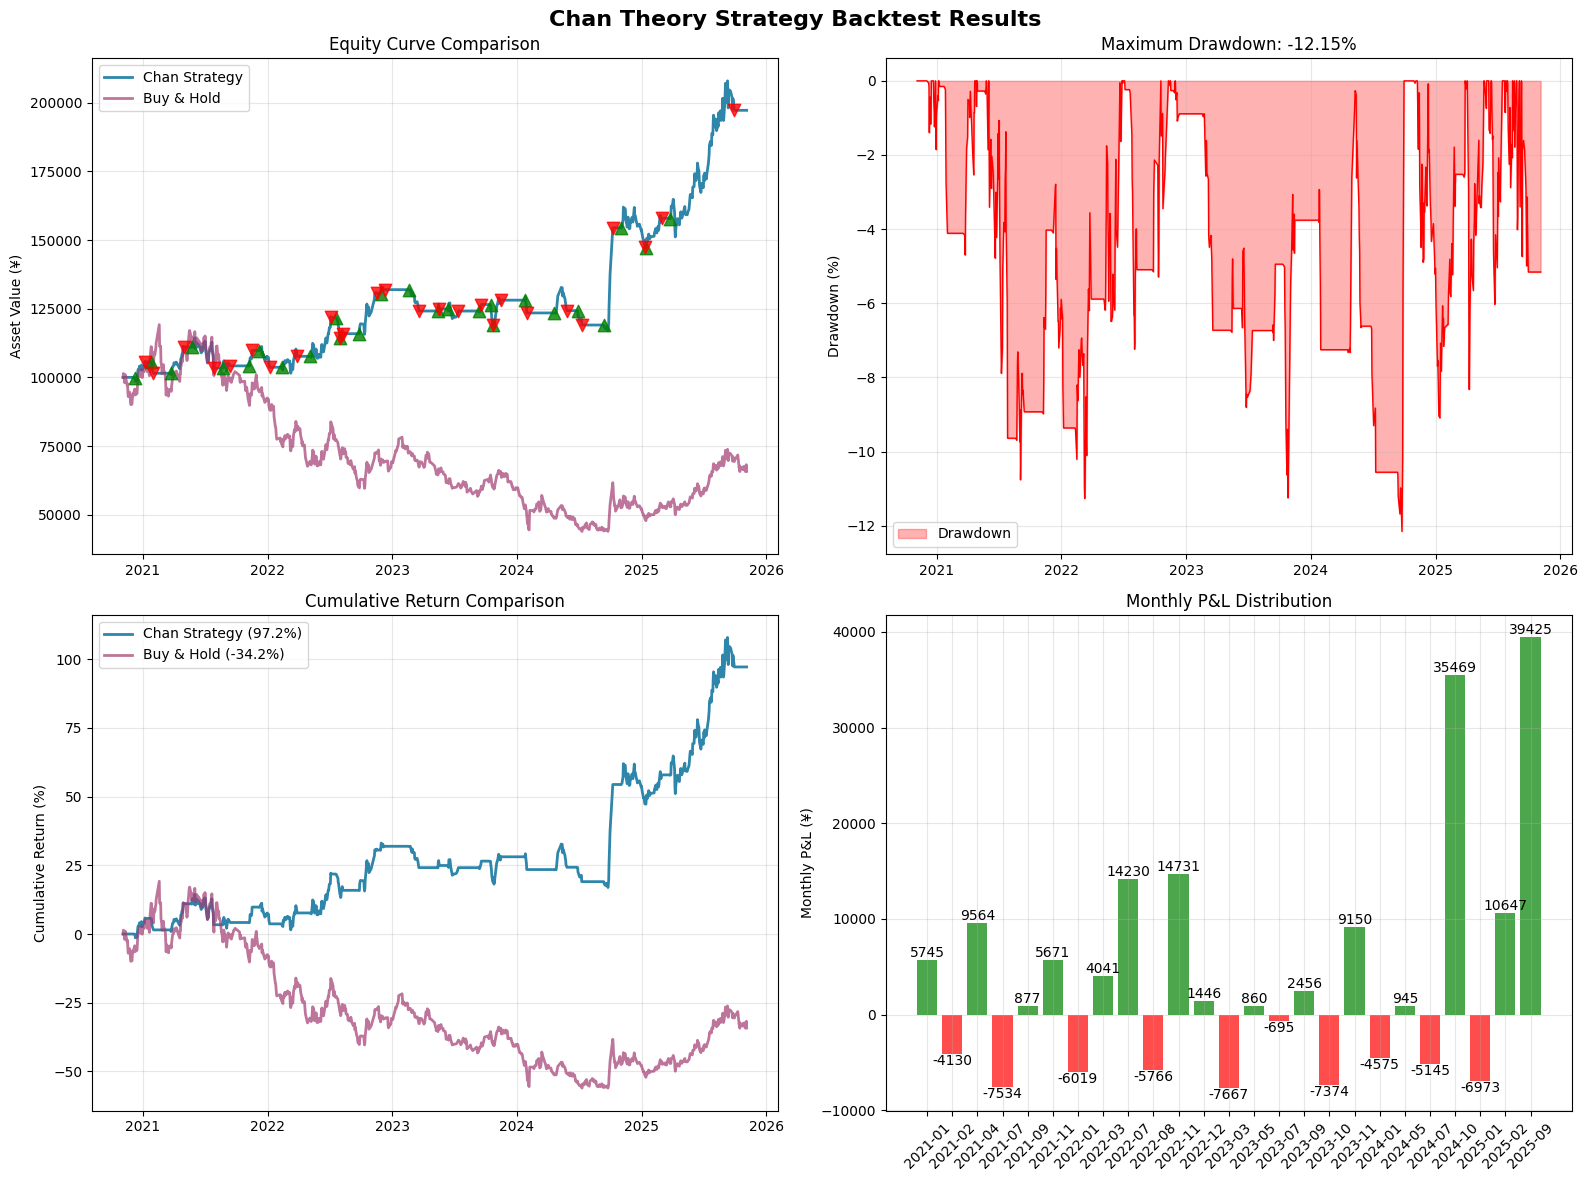

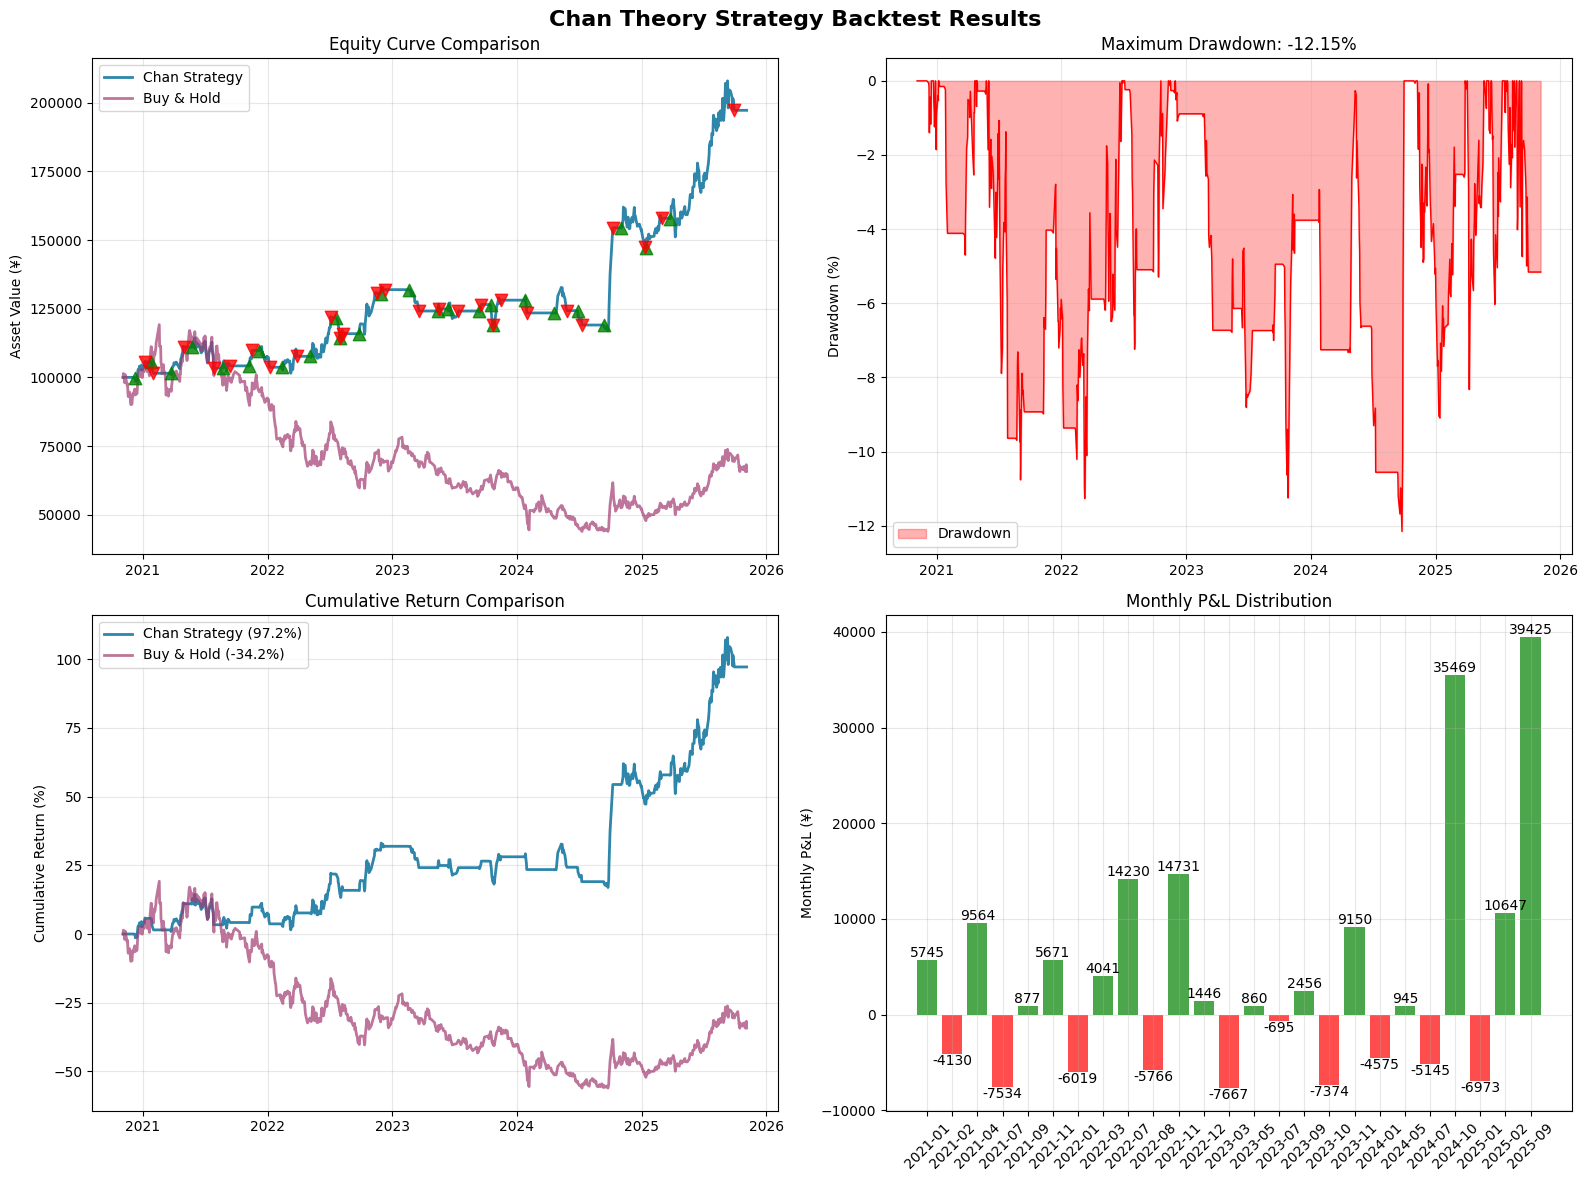

In [61]:
# Backtest results visualization
def plot_backtest_results():
    # Prepare data
    equity_df = pd.DataFrame(equity_curve)
    equity_df['date'] = pd.to_datetime(equity_df['date'])
    
    # Calculate benchmark (buy and hold)
    initial_price = equity_df['price'].iloc[0]
    equity_df['buy_hold_value'] = (equity_df['price'] / initial_price) * backtester.initial_capital
    
    # Calculate drawdown
    peak = equity_df['total_value'].expanding().max()
    equity_df['drawdown'] = (equity_df['total_value'] - peak) / peak * 100
    
    # Create trade records DataFrame
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df['date'] = pd.to_datetime(trades_df['date'])
    
    # Create charts
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Chan Theory Strategy Backtest Results', fontsize=16, fontweight='bold')
    
    # 1. Equity curve comparison
    ax1 = axes[0, 0]
    ax1.plot(equity_df['date'], equity_df['total_value'], 
             label='Chan Strategy', color='#2E86AB', linewidth=2)
    ax1.plot(equity_df['date'], equity_df['buy_hold_value'], 
             label='Buy & Hold', color='#A23B72', linewidth=2, alpha=0.7)
    
    # Mark buy/sell points
    if not trades_df.empty:
        buy_trades = trades_df[trades_df['action'] == 'buy']
        sell_trades = trades_df[trades_df['action'] == 'sell']
        
        for _, trade in buy_trades.iterrows():
            idx = equity_df[equity_df['date'] <= trade['date']].index[-1]
            ax1.scatter(trade['date'], equity_df.loc[idx, 'total_value'], 
                       color='green', marker='^', s=80, zorder=5, alpha=0.8)
        
        for _, trade in sell_trades.iterrows():
            idx = equity_df[equity_df['date'] <= trade['date']].index[-1]
            ax1.scatter(trade['date'], equity_df.loc[idx, 'total_value'], 
                       color='red', marker='v', s=80, zorder=5, alpha=0.8)
    
    ax1.set_title('Equity Curve Comparison')
    ax1.set_ylabel('Asset Value (¥)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Maximum drawdown
    ax2 = axes[0, 1]
    ax2.fill_between(equity_df['date'], equity_df['drawdown'], 0, 
                     color='red', alpha=0.3, label='Drawdown')
    ax2.plot(equity_df['date'], equity_df['drawdown'], color='red', linewidth=1)
    ax2.set_title(f'Maximum Drawdown: {stats["max_drawdown_pct"]:.2f}%')
    ax2.set_ylabel('Drawdown (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Cumulative return comparison
    ax3 = axes[1, 0]
    strategy_returns = (equity_df['total_value'] / backtester.initial_capital - 1) * 100
    buyhold_returns = (equity_df['buy_hold_value'] / backtester.initial_capital - 1) * 100
    
    ax3.plot(equity_df['date'], strategy_returns, 
             label=f'Chan Strategy ({strategy_returns.iloc[-1]:.1f}%)', 
             color='#2E86AB', linewidth=2)
    ax3.plot(equity_df['date'], buyhold_returns, 
             label=f'Buy & Hold ({buyhold_returns.iloc[-1]:.1f}%)', 
             color='#A23B72', linewidth=2, alpha=0.7)
    
    ax3.set_title('Cumulative Return Comparison')
    ax3.set_ylabel('Cumulative Return (%)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Monthly P&L distribution
    ax4 = axes[1, 1]
    if not trades_df.empty:
        monthly_profits = trades_df[trades_df['action'] == 'sell'].copy()
        if not monthly_profits.empty:
            monthly_profits['month'] = monthly_profits['date'].dt.to_period('M')
            monthly_summary = monthly_profits.groupby('month')['profit'].sum()
            
            colors = ['green' if x >= 0 else 'red' for x in monthly_summary.values]
            bars = ax4.bar(range(len(monthly_summary)), monthly_summary.values, 
                          color=colors, alpha=0.7)
            ax4.set_title('Monthly P&L Distribution')
            ax4.set_ylabel('Monthly P&L (¥)')
            ax4.set_xticks(range(len(monthly_summary)))
            ax4.set_xticklabels([str(m) for m in monthly_summary.index], rotation=45)
            
            # Add value labels
            for i, bar in enumerate(bars):
                height = bar.get_height()
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.0f}', ha='center', va='bottom' if height >= 0 else 'top')
        else:
            ax4.text(0.5, 0.5, 'No complete trade records', ha='center', va='center', 
                    transform=ax4.transAxes, fontsize=14)
            ax4.set_title('Monthly P&L Distribution')
    else:
        ax4.text(0.5, 0.5, 'No trade records', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=14)
        ax4.set_title('Monthly P&L Distribution')
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Generate visualization results
plot_backtest_results()

In [62]:
# Detailed trade analysis
def analyze_trades_detail():
    if not trades:
        print("No trade records available for analysis")
        return
    
    trades_df = pd.DataFrame(trades)
    trades_df['date'] = pd.to_datetime(trades_df['date'])
    
    print("\n=== Detailed Trade Analysis ===")
    
    # Analysis by trading pattern
    sell_trades = trades_df[trades_df['action'] == 'sell'].copy()
    if not sell_trades.empty:
        print("\nAnalysis by signal type:")
        pattern_stats = sell_trades.groupby('reason').agg({
            'profit': ['count', 'sum', 'mean'],
            'return_rate': 'mean'
        }).round(3)
        
        for pattern in pattern_stats.index:
            count = pattern_stats.loc[pattern, ('profit', 'count')]
            total_profit = pattern_stats.loc[pattern, ('profit', 'sum')]
            avg_profit = pattern_stats.loc[pattern, ('profit', 'mean')]
            avg_return = pattern_stats.loc[pattern, ('return_rate', 'mean')] * 100
            
            print(f"  {pattern}:")
            print(f"    Trade count: {count}")
            print(f"    Total P&L: ¥{total_profit:,.0f}")
            print(f"    Average P&L: ¥{avg_profit:,.0f}")
            print(f"    Average return: {avg_return:.2f}%")
    
    # Recent 10 trades
    print(f"\nRecent 10 trades detail:")
    recent_trades = trades_df.tail(10)[['date', 'action', 'price', 'reason', 'profit', 'return_rate']].copy()
    if 'profit' in recent_trades.columns:
        recent_trades['profit'] = recent_trades['profit'].fillna(0)
    if 'return_rate' in recent_trades.columns:
        recent_trades['return_rate'] = (recent_trades['return_rate'].fillna(0) * 100).round(2)
    
    for _, trade in recent_trades.iterrows():
        date_str = trade['date'].strftime('%Y-%m-%d') if pd.notna(trade['date']) else 'N/A'
        profit_str = f"¥{trade.get('profit', 0):,.0f}" if 'profit' in trade else "N/A"
        return_str = f"{trade.get('return_rate', 0):.2f}%" if 'return_rate' in trade else "N/A"
        
        print(f"  {date_str}: {trade['action']} @¥{trade['price']:.2f} "
              f"- {trade.get('reason', 'N/A')} - P&L:{profit_str} ({return_str})")

analyze_trades_detail()


=== Detailed Trade Analysis ===

Analysis by signal type:
  Stop loss (ATR-based):
    Trade count: 8
    Total P&L: ¥-50,722
    Average P&L: ¥-6,340
    Average return: -7.00%
  er_mai - Er mai: Pullback after yi mai did not make new high:
    Trade count: 1
    Total P&L: ¥1,446
    Average P&L: ¥1,446
    Average return: 1.80%
  san_mai - San mai: Pullback near lower edge did not strongly penetrate (dist 0.025):
    Trade count: 1
    Total P&L: ¥-695
    Average P&L: ¥-695
    Average return: -0.70%
  yi_mai - Segment reversal yi mai:
    Trade count: 16
    Total P&L: ¥149,348
    Average P&L: ¥9,334
    Average return: 11.00%

Recent 10 trades detail:
  2024-06-27: buy @¥0.63 - yi_mai - Segment reversal yi mai - P&L:¥0 (0.00%)
  2024-07-09: sell @¥0.60 - Stop loss (ATR-based) - P&L:¥-5,145 (-5.17%)
  2024-09-12: buy @¥0.61 - yi_mai - Segment reversal yi mai - P&L:¥0 (0.00%)
  2024-10-08: sell @¥0.84 - yi_mai - Segment reversal yi mai - P&L:¥35,469 (37.24%)
  2024-11-01: buy @¥0

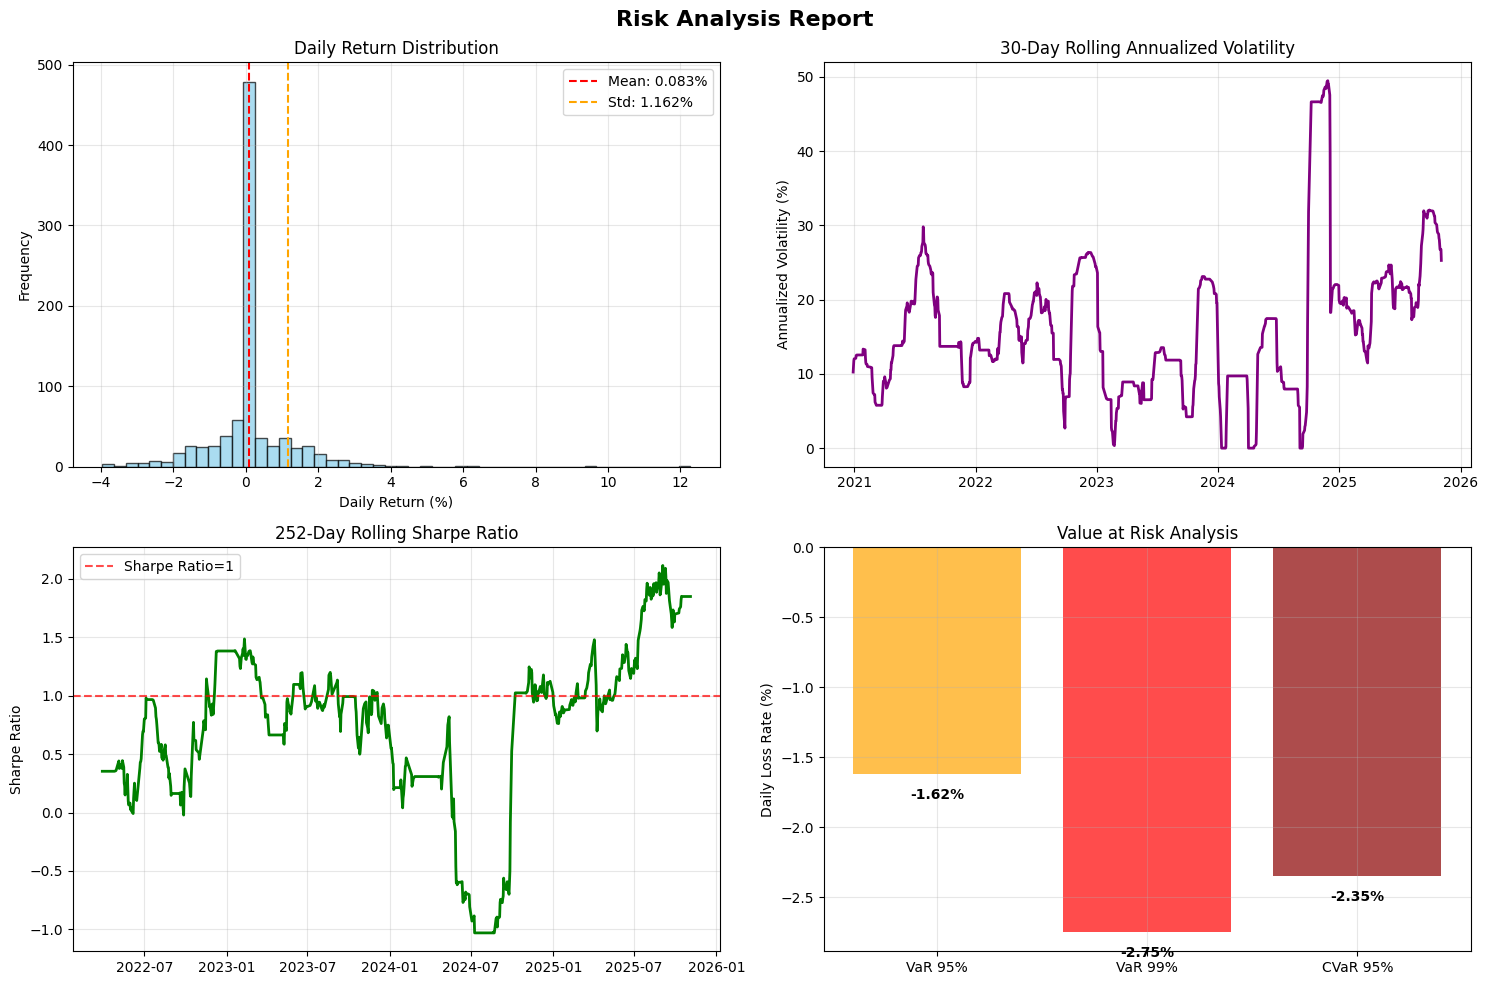


=== Risk Statistical Indicators ===
Daily return mean: 0.083%
Daily return std: 1.162%
Annualized volatility: 18.44%
Skewness: 2.324
Kurtosis: 21.084
VaR (95%): -1.62%
VaR (99%): -2.75%
CVaR (95%): -2.35%
Maximum consecutive losses: 1


In [63]:
# Risk indicator analysis
def plot_risk_analysis():
    equity_df = pd.DataFrame(equity_curve)
    equity_df['date'] = pd.to_datetime(equity_df['date'])
    
    # Calculate daily returns
    equity_df['daily_return'] = equity_df['total_value'].pct_change()
    daily_returns = equity_df['daily_return'].dropna()
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Risk Analysis Report', fontsize=16, fontweight='bold')
    
    # 1. Daily return distribution
    ax1 = axes[0, 0]
    ax1.hist(daily_returns * 100, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.axvline(daily_returns.mean() * 100, color='red', linestyle='--', 
                label=f'Mean: {daily_returns.mean()*100:.3f}%')
    ax1.axvline(daily_returns.std() * 100, color='orange', linestyle='--', 
                label=f'Std: {daily_returns.std()*100:.3f}%')
    ax1.set_title('Daily Return Distribution')
    ax1.set_xlabel('Daily Return (%)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Rolling volatility
    ax2 = axes[0, 1]
    rolling_vol = daily_returns.rolling(30).std() * np.sqrt(252) * 100
    ax2.plot(equity_df['date'][30:], rolling_vol[29:], color='purple', linewidth=2)
    ax2.set_title('30-Day Rolling Annualized Volatility')
    ax2.set_ylabel('Annualized Volatility (%)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Rolling Sharpe ratio
    ax3 = axes[1, 0]
    rolling_returns = daily_returns.rolling(252).mean() * 252  # Annualized return
    rolling_sharpe = (rolling_returns - 0.03) / (daily_returns.rolling(252).std() * np.sqrt(252))
    ax3.plot(equity_df['date'][252:], rolling_sharpe[251:], color='green', linewidth=2)
    ax3.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Sharpe Ratio=1')
    ax3.set_title('252-Day Rolling Sharpe Ratio')
    ax3.set_ylabel('Sharpe Ratio')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. VaR and CVaR analysis
    ax4 = axes[1, 1]
    var_95 = np.percentile(daily_returns, 5) * 100
    var_99 = np.percentile(daily_returns, 1) * 100
    cvar_95 = daily_returns[daily_returns <= np.percentile(daily_returns, 5)].mean() * 100
    
    ax4.bar(['VaR 95%', 'VaR 99%', 'CVaR 95%'], [var_95, var_99, cvar_95], 
            color=['orange', 'red', 'darkred'], alpha=0.7)
    ax4.set_title('Value at Risk Analysis')
    ax4.set_ylabel('Daily Loss Rate (%)')
    
    for i, v in enumerate([var_95, var_99, cvar_95]):
        ax4.text(i, v-0.1, f'{v:.2f}%', ha='center', va='top', fontweight='bold')
    
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print risk statistics
    print("\n=== Risk Statistical Indicators ===")
    print(f"Daily return mean: {daily_returns.mean()*100:.3f}%")
    print(f"Daily return std: {daily_returns.std()*100:.3f}%")
    print(f"Annualized volatility: {daily_returns.std()*np.sqrt(252)*100:.2f}%")
    print(f"Skewness: {daily_returns.skew():.3f}")
    print(f"Kurtosis: {daily_returns.kurtosis():.3f}")
    print(f"VaR (95%): {var_95:.2f}%")
    print(f"VaR (99%): {var_99:.2f}%")
    print(f"CVaR (95%): {cvar_95:.2f}%")
    
    # Calculate maximum consecutive losses
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        sell_trades = trades_df[trades_df['action'] == 'sell'].copy()
        if not sell_trades.empty:
            profits = sell_trades['profit'].values
            max_consecutive_loss = 0
            current_loss_streak = 0
            
            for profit in profits:
                if profit < 0:
                    current_loss_streak += 1
                    max_consecutive_loss = max(max_consecutive_loss, current_loss_streak)
                else:
                    current_loss_streak = 0
            
            print(f"Maximum consecutive losses: {max_consecutive_loss}")

plot_risk_analysis()

In [64]:
# Investment Advice Analysis Based on Latest Indicators

# First, create the subset variables that were previously defined in the plot function
price_df = chan.comp_df.copy()
price_df['date'] = pd.to_datetime(price_df['date'])

# Use the same filtering logic as in the plot function
last_n = 60  # or whatever value you want to use for recent analysis
subset_df = price_df.tail(last_n)

low_i = subset_df['index'].min()
high_i = subset_df['index'].max()

# Helper function to filter objects by index range (copied from plot_util.py)
def _filter_by_index_range(price_df, items, key='index', low_i=None, high_i=None):
    if low_i is None or high_i is None:
        return items
    out = []
    for it in items:
        idx_val = it.get(key) if isinstance(it, dict) else None
        if idx_val is not None and low_i <= idx_val <= high_i:
            out.append(it)
    return out

# Create filtered versions of the data for the subset
strokes_sub = _filter_by_index_range(price_df, strokes, key='start_index', low_i=low_i, high_i=high_i)
zhongshu_sub = _filter_by_index_range(price_df, zhongshu, key='start_index', low_i=low_i, high_i=high_i)

def analyze_current_market_position():
    # Get latest data points
    latest_price = subset_df['close'].iloc[-1]
    latest_date = subset_df['date'].iloc[-1]
    latest_index = subset_df['index'].iloc[-1]
    
    print("=== CURRENT MARKET ANALYSIS ===")
    print(f"Latest Price: ${latest_price:.3f}")
    print(f"Analysis Date: {latest_date.strftime('%Y-%m-%d')}")
    print(f"Index Position: {latest_index}")

        
    current_zhongshu = zhongshu_sub[-1]  # Most recent zhongshu
    zs_upper = current_zhongshu['upper']
    zs_lower = current_zhongshu['lower']
    zs_center = current_zhongshu['center']
    
    print(f"\n=== KEY LEVELS ===")
    print(f"Current Zhongshu Range: ${zs_lower:.3f} - ${zs_upper:.3f}")
    print(f"Zhongshu Center: ${zs_center:.3f}")
    
    # Position relative to zhongshu
    if latest_price > zs_upper:
        zs_position = "ABOVE zhongshu - Strong bullish"
    elif latest_price < zs_lower:
        zs_position = "BELOW zhongshu - Strong bearish"
    else:
        zs_position = "WITHIN zhongshu - Consolidation"
    
    print(f"Price Position: {zs_position}")
    
    # Analyze recent strokes
    if len(strokes_sub) >= 3:
        recent_strokes = strokes_sub[-3:]  # Last 3 strokes
        stroke_directions = [s['direction'] for s in recent_strokes]
        
        print(f"\n=== STROKE ANALYSIS ===")
        print(f"Recent stroke pattern: {' -> '.join(stroke_directions)}")
        
        # Check for potential signals
        latest_stroke = strokes_sub[-1]
        stroke_strength = abs(latest_stroke['end_price'] - latest_stroke['start_price']) / latest_stroke['start_price']
        
        print(f"Latest stroke: {latest_stroke['direction']} ({stroke_strength:.2%} move)")
    else:
        print(f"\n=== STROKE ANALYSIS ===")
        print("Insufficient stroke data for analysis")
        latest_stroke = None
        stroke_strength = 0
    
    # Risk assessment using ATR
    current_atr = atr_map.get(latest_index, 0.02)
    print(f"Current ATR: {current_atr:.2%} (volatility measure)")
    
    # Generate recommendation
    print(f"\n=== INVESTMENT RECOMMENDATION ===")
    
    recommendation = "HOLD"
    confidence = 0.5
    risk_level = "MEDIUM"
    
    # Decision logic based on Chan Theory
    if latest_stroke and latest_price > zs_upper and latest_stroke['direction'] == 'up':
        if stroke_strength > 0.05:  # Strong upward move
            recommendation = "BUY"
            confidence = 0.75
            risk_level = "MEDIUM-HIGH"
        else:
            recommendation = "CAUTIOUS BUY"
            confidence = 0.6
    
    elif latest_stroke and latest_price < zs_lower and latest_stroke['direction'] == 'down':
        if stroke_strength > 0.05:  # Strong downward move
            recommendation = "SELL/AVOID"
            confidence = 0.75
            risk_level = "HIGH"
        else:
            recommendation = "WAIT"
            confidence = 0.6
    
    elif zs_lower <= latest_price <= zs_upper:
        if latest_stroke and latest_stroke['direction'] == 'up' and latest_price > zs_center:
            recommendation = "SMALL BUY"
            confidence = 0.55
        elif latest_stroke and latest_stroke['direction'] == 'down' and latest_price < zs_center:
            recommendation = "REDUCE POSITION"
            confidence = 0.55
    
    # Adjust for high volatility
    if current_atr > 0.03:
        risk_level = "HIGH"
        if "BUY" in recommendation:
            recommendation = f"CAUTIOUS {recommendation}"
    
    print(f"Recommendation: {recommendation}")
    print(f"Confidence Level: {confidence:.0%}")
    print(f"Risk Level: {risk_level}")
    
    # Entry/Exit levels
    if "BUY" in recommendation:
        entry_level = latest_price
        stop_loss = max(zs_lower, latest_price * (1 - current_atr * 2))
        take_profit = latest_price * (1 + current_atr * 3)
        
        print(f"\n=== TRADING LEVELS ===")
        print(f"Entry Level: ${entry_level:.3f}")
        print(f"Stop Loss: ${stop_loss:.3f} ({((stop_loss/entry_level-1)*100):+.1f}%)")
        print(f"Take Profit: ${take_profit:.3f} ({((take_profit/entry_level-1)*100):+.1f}%)")
        
    elif "SELL" in recommendation or "REDUCE" in recommendation:
        exit_level = latest_price
        reentry_level = zs_lower * 0.98
        
        print(f"\n=== TRADING LEVELS ===")
        print(f"Exit Level: ${exit_level:.3f}")
        print(f"Re-entry Level: ${reentry_level:.3f}")
    
    # Risk management advice
    print(f"\n=== RISK MANAGEMENT ===")
    print(f"Position Size: Due to {risk_level} risk, consider {'20-30%' if risk_level == 'HIGH' else '40-60%' if risk_level == 'MEDIUM-HIGH' else '60-80%'} of normal position")
    print(f"Time Horizon: {'Short-term (1-2 weeks)' if current_atr > 0.025 else 'Medium-term (1-2 months)'}")
    
    # Market context
    print(f"\n=== MARKET CONTEXT ===")
    recent_performance = (latest_price / subset_df['close'].iloc[0] - 1) * 100
    print(f"Recent Performance: {recent_performance:+.1f}% over last {len(subset_df)} periods")
    
    return {
        'recommendation': recommendation,
        'confidence': confidence,
        'risk_level': risk_level,
        'entry_price': latest_price,
        'key_levels': {
            'zs_upper': zs_upper,
            'zs_lower': zs_lower,
            'zs_center': zs_center
        }
    }

# Execute analysis
advice = analyze_current_market_position()

=== CURRENT MARKET ANALYSIS ===
Latest Price: $0.894
Analysis Date: 2025-11-04
Index Position: 1191

=== KEY LEVELS ===
Current Zhongshu Range: $0.899 - $0.927
Zhongshu Center: $0.913
Price Position: BELOW zhongshu - Strong bearish

=== STROKE ANALYSIS ===
Recent stroke pattern: up -> down -> up
Latest stroke: up (4.03% move)
Current ATR: 3.19% (volatility measure)

=== INVESTMENT RECOMMENDATION ===
Recommendation: HOLD
Confidence Level: 50%
Risk Level: HIGH

=== RISK MANAGEMENT ===
Position Size: Due to HIGH risk, consider 20-30% of normal position
Time Horizon: Short-term (1-2 weeks)

=== MARKET CONTEXT ===
Recent Performance: +6.2% over last 60 periods


# Detailed Boduan Indicators Explanation

The boduan plot displays 4 panels with multiple technical indicators. Let's examine what each number means:

In [48]:
def analyze_specific_numbers():
    """
    Analyze specific numerical values from the boduan indicators
    """
    print("=" * 80)
    print("CURRENT NUMERICAL VALUES ANALYSIS")
    print("=" * 80)
    
    # Get recent data subset (last 10 values for trend analysis)
    recent_window = 10
    
    print("\n📊 CURRENT VALUES (Most Recent):")
    print("-" * 50)
    
    # C1/C2 Analysis with specific numbers
    c1_values = boduan_results.get('C1', [])
    c2_values = boduan_results.get('C2', [])
    
    if len(c1_values) >= recent_window:
        recent_c1 = c1_values[-recent_window:]
        recent_c2 = c2_values[-recent_window:]
        
        current_c1 = recent_c1[-1]
        current_c2 = recent_c2[-1]
        
        print(f"C1 (Williams Modified): {current_c1:.2f}")
        print(f"C2 (C1 Smoothed):      {current_c2:.2f}")
        print(f"C1-C2 Difference:      {current_c1-current_c2:+.2f}")
        
        # Trend analysis
        c1_trend = recent_c1[-1] - recent_c1[-5] if len(recent_c1) >= 5 else 0
        print(f"C1 5-period trend:     {c1_trend:+.2f} ({'Rising' if c1_trend > 0 else 'Falling' if c1_trend < 0 else 'Flat'})")
        
        # Signal analysis
        if current_c1 > current_c2:
            print("Signal Status: C1 > C2 (Bullish momentum)")
        else:
            print("Signal Status: C1 < C2 (Bearish momentum)")
            
        # Extreme levels
        if current_c1 < 20:
            print("⚠️  EXTREME: C1 in oversold territory (<20)")
        elif current_c1 > 80:
            print("⚠️  EXTREME: C1 in overbought territory (>80)")
    
    print()
    
    # RSI Analysis
    rsi_values = boduan_results.get('RSI5', [])
    if len(rsi_values) >= recent_window:
        recent_rsi = rsi_values[-recent_window:]
        current_rsi = recent_rsi[-1]
        
        print(f"RSI5 Current:          {current_rsi:.2f}")
        
        # RSI interpretation
        if current_rsi > 70:
            rsi_status = "OVERBOUGHT (>70)"
        elif current_rsi < 30:
            rsi_status = "OVERSOLD (<30)"
        elif current_rsi > 50:
            rsi_status = "BULLISH (>50)"
        else:
            rsi_status = "BEARISH (<50)"
        
        print(f"RSI5 Status:           {rsi_status}")
        
        # RSI trend
        rsi_trend = recent_rsi[-1] - recent_rsi[-5] if len(recent_rsi) >= 5 else 0
        print(f"RSI5 5-period trend:   {rsi_trend:+.2f}")
    
    print()
    
    # ADX/DXR Analysis
    adx_values = boduan_results.get('ADX', [])
    dxr_values = boduan_results.get('DXR', [])
    
    if len(adx_values) >= recent_window:
        current_adx = adx_values[-1]
        current_dxr = dxr_values[-1] if len(dxr_values) > 0 else 0
        
        print(f"ADX (Trend Strength):  {current_adx:.2f}")
        
        # ADX interpretation
        if current_adx > 50:
            adx_status = "VERY STRONG TREND"
        elif current_adx > 40:
            adx_status = "STRONG TREND"
        elif current_adx > 25:
            adx_status = "MODERATE TREND"
        elif current_adx > 15:
            adx_status = "WEAK TREND"
        else:
            adx_status = "NO TREND/SIDEWAYS"
        
        print(f"ADX Status:            {adx_status}")
        print(f"DXR (Combined):        {current_dxr:.2f}")
    
    print()
    
    # Signal Analysis
    print("🚨 CURRENT SIGNALS:")
    print("-" * 30)
    
    signals = ['ready', 'go', 'tiao', 'qiang_la_sheng', 'kai_shi_la_sheng']
    signal_names = ['Ready', 'Go', 'Jump', 'Strong Pull', 'Start Pull']
    
    active_signals = []
    for i, signal in enumerate(signals):
        values = boduan_results.get(signal, [])
        if len(values) > 0 and values[-1] > 0:
            active_signals.append(signal_names[i])
            print(f"✅ {signal_names[i]}: ACTIVE")
    
    if not active_signals:
        print("❌ No active signals")
    else:
        print(f"\n🎯 {len(active_signals)} signal(s) currently active")
    
    print()
    
    # Statistical Analysis
    print("📈 STATISTICAL SUMMARY (Last 10 periods):")
    print("-" * 45)
    
    if len(c1_values) >= recent_window:
        recent_c1 = c1_values[-recent_window:]
        c1_avg = sum(recent_c1) / len(recent_c1)
        c1_max = max(recent_c1)
        c1_min = min(recent_c1)
        c1_volatility = (c1_max - c1_min) / c1_avg * 100
        
        print(f"C1 Average:     {c1_avg:.2f}")
        print(f"C1 Range:       {c1_min:.2f} - {c1_max:.2f}")
        print(f"C1 Volatility:  {c1_volatility:.1f}%")
    
    if len(rsi_values) >= recent_window:
        recent_rsi = rsi_values[-recent_window:]
        rsi_avg = sum(recent_rsi) / len(recent_rsi)
        
        print(f"RSI5 Average:   {rsi_avg:.2f}")
        
        # Count extreme readings
        oversold_count = sum(1 for x in recent_rsi if x < 30)
        overbought_count = sum(1 for x in recent_rsi if x > 70)
        
        print(f"Oversold days:  {oversold_count}/10")
        print(f"Overbought days:{overbought_count}/10")
    
    # Trading Implications
    print()
    print("💡 TRADING IMPLICATIONS:")
    print("-" * 35)
    
    # Combine indicators for advice
    risk_level = "MEDIUM"
    
    if len(c1_values) > 0 and len(rsi_values) > 0:
        current_c1 = c1_values[-1]
        current_rsi = rsi_values[-1]
        
        if current_c1 < 20 and current_rsi < 30:
            print("🟢 STRONG BUY: Both C1 and RSI in oversold territory")
            risk_level = "LOW"
        elif current_c1 > 80 and current_rsi > 70:
            print("🔴 STRONG SELL: Both C1 and RSI in overbought territory")
            risk_level = "HIGH"
        elif len(active_signals) >= 2:
            print("🟡 MODERATE BUY: Multiple signals active")
            risk_level = "MEDIUM"
        else:
            print("⚪ NEUTRAL: Wait for clearer signals")
    
    print(f"Current Risk Level: {risk_level}")

# Execute the numerical analysis
analyze_specific_numbers()

CURRENT NUMERICAL VALUES ANALYSIS

📊 CURRENT VALUES (Most Recent):
--------------------------------------------------
C1 (Williams Modified): 55.89
C2 (C1 Smoothed):      68.68
C1-C2 Difference:      -12.79
C1 5-period trend:     -12.14 (Falling)
Signal Status: C1 < C2 (Bearish momentum)

RSI5 Current:          52.73
RSI5 Status:           BULLISH (>50)
RSI5 5-period trend:   -9.10

ADX (Trend Strength):  16.43
ADX Status:            WEAK TREND
DXR (Combined):        70.16

🚨 CURRENT SIGNALS:
------------------------------
❌ No active signals

📈 STATISTICAL SUMMARY (Last 10 periods):
---------------------------------------------
C1 Average:     56.58
C1 Range:       34.85 - 78.28
C1 Volatility:  76.8%
RSI5 Average:   49.35
Oversold days:  0/10
Overbought days:0/10

💡 TRADING IMPLICATIONS:
-----------------------------------
⚪ NEUTRAL: Wait for clearer signals
Current Risk Level: MEDIUM
